In [1]:
import nilearn.image as ni
import nibabel as nb
from nilearn.plotting import plot_anat, plot_prob_atlas, show, plot_stat_map
import SimpleITK as sitk
from utils import pad_nifti_image, multires_registration
from aligner import Aligner
from warp_utils import apply_warp
import numpy as np
from monai.transforms import LoadImage, EnsureChannelFirst
from warper import Warper


# %matplotlib notebook
# import gui

/home/codespace/.python/current/lib/python3.10/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: The following kwargs were not used by contour: 'color'
  im = getattr(ax, type)(data_2d.copy(),


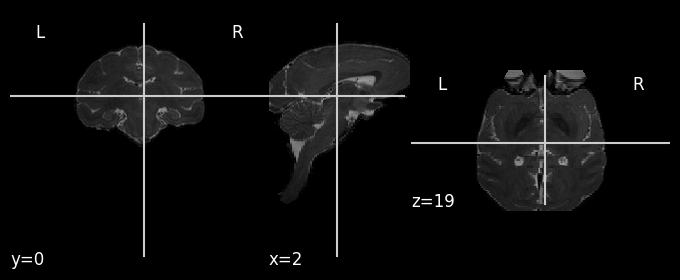

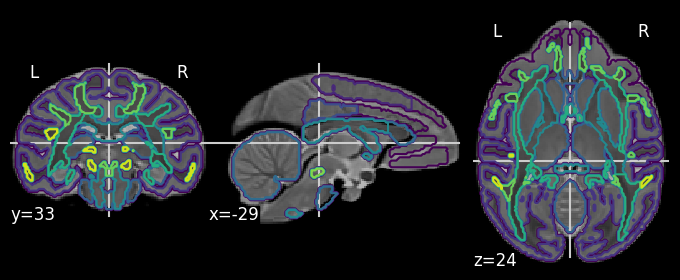

In [2]:
sub_bse_t2_orig = "/deneb_disk/macaque_atlas_data/test_data/MAC10.bse.nii.gz"
sub_bse_t2 = "/deneb_disk/macaque_atlas_data/test_data/MAC10_pad.bse.nii.gz"
sub_mask_t2_orig = "/deneb_disk/macaque_atlas_data/test_data/MAC10.mask.nii.gz"
sub_mask_t2 = "/deneb_disk/macaque_atlas_data/test_data/MAC10_pad.mask.nii.gz"

atlas_bse_t2 = "/deneb_disk/macaque_atlas_data/macaque_atlas/ONPRC18_atlas_v1/ONPRC18_Templates/ONPRC18_T2W_brain.nii.gz"
atlas_labels = "/deneb_disk/macaque_atlas_data/macaque_atlas/ONPRC18_atlas_v1/ONPRC18_Labelmaps/ONPRC18_GrayMatterWhiteMatterLabelmap.nii.gz"

centered_atlas = "/deneb_disk/macaque_atlas_data/test_data/atlas.nii.gz"
centered_atlas_labels = "/deneb_disk/macaque_atlas_data/test_data/atlas.label.nii.gz"

lin_reg_map_file = "/deneb_disk/macaque_atlas_data/test_data/lin_ddf.nii.gz"
centered_atlas_linreg = "/deneb_disk/macaque_atlas_data/test_data/atlas_lin.nii.gz"
centered_atlas_linreg_labels = (
    "/deneb_disk/macaque_atlas_data/test_data/atlas_lin.label.nii.gz"
)

nonlin_reg_map_file = "/deneb_disk/macaque_atlas_data/test_data/nonlin_ddf.nii.gz"
centered_atlas_nonlinreg = (
    "/deneb_disk/macaque_atlas_data/test_data/atlas_nonlin.nii.gz"
)
centered_atlas_nonlinreg_labels = (
    "/deneb_disk/macaque_atlas_data/test_data/atlas_nonlin.label.nii.gz"
)
centered_atlas_nonlinreg_labels_filled = (
    "/deneb_disk/macaque_atlas_data/test_data/atlas_nonlin_filled.label.nii.gz"
)
jac_det_file = "/deneb_disk/macaque_atlas_data/test_data/jacobian_det.nii.gz"

PAD = 10

plot_anat(sub_bse_t2_orig)
d = plot_anat(atlas_bse_t2)
d.add_contours(atlas_labels, color="r")

In [ ]:
pad_nifti_image(sub_bse_t2_orig, sub_bse_t2, PAD)
pad_nifti_image(sub_mask_t2_orig, sub_mask_t2, PAD)
plot_anat(sub_bse_t2)

In [ ]:
fixed_image = sitk.ReadImage(sub_bse_t2, sitk.sitkFloat32)
moving_image = sitk.ReadImage(atlas_bse_t2, sitk.sitkFloat32)
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)

final_transform, _ = multires_registration(fixed_image, moving_image, initial_transform)

moved_image = sitk.Resample(moving_image, fixed_image, final_transform)

sitk.WriteImage(moved_image, centered_atlas)

moving_image = sitk.ReadImage(atlas_labels, sitk.sitkUInt16)
moved_image = sitk.Resample(
    moving_image,
    fixed_image,
    transform=final_transform,
    interpolator=sitk.sitkNearestNeighbor,
)
sitk.WriteImage(moved_image, centered_atlas_labels)


plot_anat(centered_atlas, cut_coords=(0, 0, 0))
plot_anat(sub_bse_t2, cut_coords=(0, 0, 0))
plot_anat(centered_atlas_labels, cut_coords=(0, 0, 0))

show()

In [ ]:
aligner = Aligner()
aligner.affine_reg(
    fixed_file=sub_bse_t2,
    moving_file=centered_atlas,
    output_file=centered_atlas_linreg,
    ddf_file=lin_reg_map_file,
    loss="cc",
)

plot_anat(sub_bse_t2, cut_coords=(0, 0, 0))
plot_anat(centered_atlas, cut_coords=(0, 0, 0))
plot_anat(centered_atlas_linreg, cut_coords=(0, 0, 0))

In [ ]:
disp_field, meta = LoadImage()(lin_reg_map_file)
disp_field = EnsureChannelFirst()(disp_field)
print(disp_field.shape)

at1, meta = LoadImage()(centered_atlas_labels)
at_lab = EnsureChannelFirst()(at1)
print(at_lab.shape)

warped_lab = apply_warp(
    disp_field[None,], at_lab[None,], at_lab[None,], interp_mode="nearest"
)
nb.save(
    nb.Nifti1Image(warped_lab[0, 0].detach().cpu().numpy(), at_lab.affine),
    centered_atlas_linreg_labels,
)

In [ ]:
d = plot_anat(sub_bse_t2, vmax=1400)
d.add_contours(centered_atlas_labels, cmap="prism")
d = plot_anat(sub_bse_t2, vmax=1400)
d.add_contours(centered_atlas_linreg_labels, cmap="prism")

In [8]:
nonlin_reg = Warper()
nonlin_reg.nonlinear_reg(
    target_file=sub_bse_t2,
    moving_file=centered_atlas_linreg,
    output_file=centered_atlas_nonlinreg,
    ddf_file=nonlin_reg_map_file,
    reg_penalty=1,
    nn_input_size=64,
    lr=1e-4,
    max_epochs=5000,
    loss="cc",
    jacobian_determinant_file=jac_det_file,
)

In [ ]:
disp_field, meta = LoadImage()(nonlin_reg_map_file)
disp_field = EnsureChannelFirst()(disp_field)
print(disp_field.shape)

at1, meta = LoadImage()(centered_atlas_linreg_labels)
at_lab = EnsureChannelFirst()(at1)
print(at_lab.shape)

warped_lab = apply_warp(
    disp_field[None,], at_lab[None,], at_lab[None,], interp_mode="nearest"
)
nb.save(
    nb.Nifti1Image(np.uint16(warped_lab[0, 0].detach().cpu().numpy()), at_lab.affine),
    centered_atlas_nonlinreg_labels,
)

In [ ]:
d = plot_anat(sub_bse_t2, vmax=1400)
d.add_contours(centered_atlas_linreg_labels, cmap="prism")
d = plot_anat(sub_bse_t2, vmax=1400)
d.add_contours(centered_atlas_nonlinreg_labels, cmap="prism")

In [ ]:
plot_anat(jac_det_file, colorbar=True)

jac=nb.load(jac_det_file)
jac = jac.get_fdata() - 1

from nilearn.image import new_img_like
jac = new_img_like(sub_bse_t2,jac)
plot_stat_map(jac,sub_bse_t2,title='Jac det')

Fill the gaps between the segmentations within the brain mask

In [5]:
labs = nb.load(centered_atlas_nonlinreg_labels).get_fdata()
brain_mask = nb.load(sub_mask_t2).get_fdata()

In [6]:
print(labs.shape)
print(brain_mask.shape)


(302, 106, 302)
(302, 106, 302)


In [ ]:
from scipy.interpolate import NearestNDInterpolator

known_mask = (labs != 0) & (brain_mask >0 )

# array of (number of points, 2) containing the x,y coordinates of the valid values only
xx, yy, zz = np.meshgrid(range(labs.shape[0]),range(labs.shape[1]),range(labs.shape[2]) )

xym = np.vstack( (np.ravel(xx[known_mask]), np.ravel(yy[known_mask]), np.ravel(zz(known_mask))) ).T

# the valid values in the first, second, third color channel,  as 1D arrays (in the same order as their coordinates in xym)
data0 = numpy.ravel( data[:,:,0][mask] )
data1 = numpy.ravel( data[:,:,1][mask] )
data2 = numpy.ravel( data[:,:,2][mask] )

# three separate interpolators for the separate color channels
interp0 = NearestNDInterpolator( xym, data0 )

nan_locs = np.where(np.isnan(data))

result0 = interp0(numpy.ravel(xx), numpy.ravel(yy)).reshape( xx.shape )


In [3]:
import numpy as np
import nibabel as nib
from scipy.interpolate import NearestNDInterpolator

def interpolate_zeros(image_data,mask_data):
    # Find zero values in the image
    zero_indices = np.argwhere((image_data == 0) & (mask_data > 0))
    
    non_zero_indices = np.argwhere((image_data != 0) & (mask_data > 0))
    non_zero_values = image_data[non_zero_indices[:, 0], non_zero_indices[:, 1], non_zero_indices[:, 2]]
    
    # Create a NearestNDInterpolator object with non-zero voxel coordinates and values
    interpolator = NearestNDInterpolator(non_zero_indices, non_zero_values)
    
    # Create an array of voxel coordinates for zero indices
    zero_coords = zero_indices[:, [0, 1, 2]]
    
    # Use the interpolator to find the nearest non-zero values for all zero voxels
    interpolated_values = interpolator(zero_coords)
    
    # Create an array of voxel values for zero indices
    interpolated_data = image_data.copy()
    interpolated_data[zero_coords[:, 0], zero_coords[:, 1], zero_coords[:, 2]] = interpolated_values
    
    return interpolated_data

# Load the NIfTI image
image_path =  centered_atlas_nonlinreg_labels# "path_to_your_image.nii.gz"  # Replace with the actual path
mask_path = sub_mask_t2
image = nib.load(image_path)
mask = nib.load(mask_path)

image_data = image.get_fdata()
mask_data = mask.get_fdata()

# Interpolate zeros in the image data
interpolated_data = interpolate_zeros(image_data,mask_data)

# Save the interpolated image as a new NIfTI file
interpolated_image = nib.Nifti1Image(interpolated_data, image.affine)
nib.save(interpolated_image, centered_atlas_nonlinreg_labels_filled)
